In [1]:
import os
import pypsa
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

idx = pd.IndexSlice

intermittent = pd.Index(["solar", "onwind", "offwind-ac", "offwind-dc"])
conventional = pd.Index(["OCGT", "CCGT", "biomass", "allam"])

In [2]:
base = Path.cwd().parent / "results" / "pypsa-fes" / "networks"

In [3]:
results = pd.DataFrame(
    np.nan,
    columns=[
        "renewable_energy",
        "dispatchable_energy",
        "dispatchable_capacity",
        "distribution",
        "tank_capacity",
        "bev_capacity",
        "system_cost",
        ],
    index=pd.MultiIndex.from_product(
        # [s := [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], s],
        [s := [0.0, 0.25, 0.5, 0.75, 1.0], s],
        names=["ev_share", "heat_share"])
        # levels=[[],[]],
        # codes=[[],[]],
)

# iterables = [["bar", "baz", "foo", "qux"], ["one", "two"]]
# pd.MultiIndex.from_product(iterables, names=["first", "second"])

def get_tank_capacity(n):
    return n.storage_units.loc[n.storage_units.carrier == "hot water tank", "p_nom"].sum()

def get_bev_capacity(n):
    # print(n.stores.loc[n.stores.carrier == "bev batteries", "e_nom"])
    return n.stores.loc[n.stores.carrier == "bev batteries", "e_nom"].sum()

def get_carrier_energy(n, carriers):
    gen = n.generators.loc[n.generators.bus.str.contains("GB")]
    value = n.generators_t.p[gen.loc[gen.carrier.isin(carriers)].index].sum().sum()

    if value:
        return value
    
    gen = n.links.loc[(n.links.bus0.str.contains("GB")) & n.links.carrier.isin(carriers)]
    return n.links_t.p0[gen.index].sum().sum()

def get_carrier_capacity(n, carriers):
    gen = n.links.loc[(n.links.bus0.str.contains("GB")) & (n.links.carrier.isin(carriers)), "p_nom_opt"]
    eta = n.links.loc[(n.links.bus0.str.contains("GB")) & (n.links.carrier.isin(carriers)), "efficiency"]
    
    print(f"carrier capacity for {carriers}.")
    print("gen ", gen.shape)
    print("gen ", gen.head())
    print("eta ", eta.shape)
    print("eta ", eta.head())
    el_cap = gen * eta

    print("el_cap ", el_cap.shape)
    print("el_cap ", el_cap.head())

    # return gen.loc[gen.carrier.isin(carriers), "p_nom_opt"].sum()
    return el_cap.sum()

get_dist_capacity = lambda n: n.links.loc[n.links.carrier == "electricity distribution grid", "p_nom_opt"].sum()


template = 'elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_{}_heat_{}.nc'
# for fn in os.listdir(base)[::-1]:

from itertools import product

for ev_share, heat_share in product(s, s):

    # if "_heat_" in fn:
    fn = template.format(ev_share, heat_share)

    # a = fn.split("_")
    # ev_share = float(a[a.index("ev") + 1])
    # heat_share = float(a[-1][:-3])

    n = pypsa.Network(base / fn)

    # print(n.storage_units.carrier.unique())
    # print(n.stores.carrier.unique())

    row = pd.Series(
        data=[
            get_carrier_energy(n, intermittent),
            get_carrier_energy(n, conventional),
            get_carrier_capacity(n, conventional),
            get_dist_capacity(n),
            get_tank_capacity(n),
            get_bev_capacity(n),
            n.objective/1.15,
        ],
        index=results.columns
    )
    # print("before")
    # print(results)


    # print(fn)
    # print(ev_share, heat_share)
    results.loc[(ev_share, heat_share), :] = row
    # print("after")
    # print(results)

    # break


# results

INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.0_heat_0.0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.0_heat_0.25.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.0_heat_0.5.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.0_heat_0.75.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.0_heat_1.0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.25_heat_0.0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.25_heat_0.25.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.25_heat_0.5.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.25_heat_0.75.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.25_heat_1.0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.5_heat_0.0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.5_heat_0.25.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.5_heat_0.5.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.5_heat_0.75.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.5_heat_1.0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.75_heat_0.0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.75_heat_0.25.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.75_heat_0.5.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.75_heat_0.75.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.75_heat_1.0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_1.0_heat_0.0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_1.0_heat_0.25.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_1.0_heat_0.5.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_1.0_heat_0.75.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_1.0_heat_1.0.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


carrier capacity for Index(['OCGT', 'CCGT', 'biomass', 'allam'], dtype='object').
gen  (34,)
gen  Link
GB0 Z10 biomass    329.700855
GB0 Z11 biomass    663.888889
GB0 Z12 biomass    742.735043
GB0 Z13 biomass    732.692308
GB0 Z14 biomass    906.623932
Name: p_nom_opt, dtype: float64
eta  (34,)
eta  Link
GB0 Z10 biomass    0.468
GB0 Z11 biomass    0.468
GB0 Z12 biomass    0.468
GB0 Z13 biomass    0.468
GB0 Z14 biomass    0.468
Name: efficiency, dtype: float64
el_cap  (34,)
el_cap  Link
GB0 Z10 biomass    154.3
GB0 Z11 biomass    310.7
GB0 Z12 biomass    347.6
GB0 Z13 biomass    342.9
GB0 Z14 biomass    424.3
dtype: float64


In [4]:
os.listdir(Path.cwd().parent/"resources"/"pypsa-fes"/"networks")
n = pypsa.Network(Path.cwd().parent/"results"/"pypsa-fes"/"networks"/"elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.4_heat_0.4.nc")

INFO:pypsa.io:Imported network elec_s_ec_lhnd__int-tank-ss-v2g_LW_2040_ev_0.4_heat_0.4.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [5]:
def get_bev_capacity(n):
    return n.stores.loc[n.stores.carrier == "bev batteries", "e_nom"].sum()

get_bev_capacity(n)

551742.9319194871

In [6]:
results

renewable_energy  dispatchable_energy  \
ev_share heat_share                                          
0.00     0.00            3.952211e+08         6.486096e+07   
         0.25            4.012825e+08         5.732770e+07   
         0.50            4.052501e+08         5.314226e+07   
         0.75            4.078853e+08         5.098006e+07   
         1.00            4.102246e+08         4.965954e+07   
0.25     0.00            4.082852e+08         4.267005e+07   
         0.25            4.116432e+08         3.874380e+07   
         0.50            4.140706e+08         3.660671e+07   
         0.75            4.162924e+08         3.499173e+07   
         1.00            4.186823e+08         3.393680e+07   
0.50     0.00            4.124267e+08         3.622295e+07   
         0.25            4.150424e+08         3.351320e+07   
         0.50            4.175858e+08         3.147317e+07   
         0.75            4.198396e+08         3.000743e+07   
         1.00            4.217063e+08         2.892852e+07   
0.75     0.00            4.158973e+08         3.163074e+07   
         0.25            4.176731e+08         2.955221e+07   
         0.50            4.199715e+08         2.802060e+07   
         0.75            4.216284e+08         2.689135e+07   
         1.00            4.242801e+08         2.427949e+07   
1.00     0.00            4.182296e+08         2.820745e+07   
         0.25            4.197353e+08         2.668258e+07   
         0.50            4.214779e+08         2.516532e+07   
         0.75            4.239163e+08         2.256410e+07   
         1.00            4.265984e+08         2.078468e+07   

                     dispatchable_capacity  distribution  tank_capacity  \
ev_share heat_share                                                       
0.00     0.00                 52913.314999  89611.338963       0.000000   
         0.25                 50159.827103  84040.951430    5570.388104   
         0.50                 48270.913051  78470.578511   11140.776207   
         0.75                 46426.216945  72907.529182   16711.164311   
         1.00                 44798.478975  71257.100580   22281.552415   
0.25     0.00                 41714.202546  68190.599728       0.000000   
         0.25                 39263.824352  68698.031397    5570.388104   
         0.50                 37457.063589  68035.383261   11140.776207   
         0.75                 35687.054003  68526.385483   16711.164311   
         1.00                 33682.070926  69391.850552   22281.552415   
0.50     0.00                 38371.813883  67813.666521       0.000000   
         0.25                 36575.282185  67132.901357    5570.388104   
         0.50                 34829.451042  67309.765242   11140.776207   
         0.75                 32736.316858  68057.919144   16711.164311   
         1.00                 30720.125457  69784.076658   22281.552415   
0.75     0.00                 36216.012617  66163.467589       0.000000   
         0.25                 34228.929534  66177.100462    5570.388104   
         0.50                 32039.524143  66790.743011   11140.776207   
         0.75                 29917.261800  68385.008971   16711.164311   
         1.00                 27917.491150  70376.394979   22281.552415   
1.00     0.00                 33665.291918  65684.311019       0.000000   
         0.25                 31629.236260  65570.411860    5570.388104   
         0.50                 29638.495450  66999.956079   11140.776207   
         0.75                 27616.088074  68884.729861   16711.164311   
         1.00                 26422.641262  70587.184035   22281.552415   

                     bev_capacity   system_cost  
ev_share heat_share                              
0.00     0.00        0.000000e+00  4.709281e+10  
         0.25        0.000000e+00  4.634601e+10  
         0.50        0.000000e+00  4.576952e+10  
         0.75        0.000000e+00  4.525627e+10  
         1.00       

In [7]:
x, y = np.meshgrid(np.linspace(0, 2, 3), np.linspace(0, 2, 3))
z = np.vstack([np.linspace(0, 2, 3) for _ in range(3)])

print(x)
print(y)
print(z)

[[0. 1. 2.]
 [0. 1. 2.]
 [0. 1. 2.]]
[[0. 0. 0.]
 [1. 1. 1.]
 [2. 2. 2.]]
[[0. 1. 2.]
 [0. 1. 2.]
 [0. 1. 2.]]


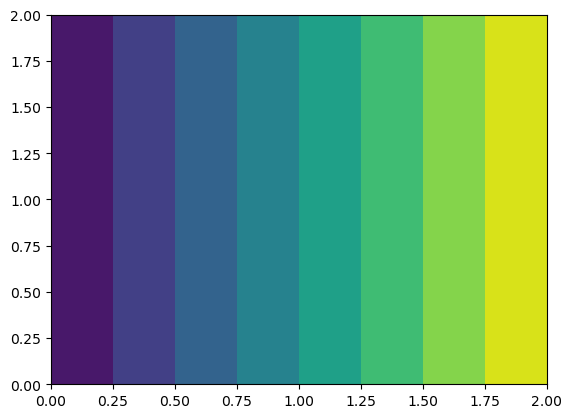

In [8]:
plt.contourf(x, y, z)

C:\Users\lukas\AppData\Local\Temp\ipykernel_28344\1968068520.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(percentages)
C:\Users\lukas\AppData\Local\Temp\ipykernel_28344\1968068520.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(percentages)


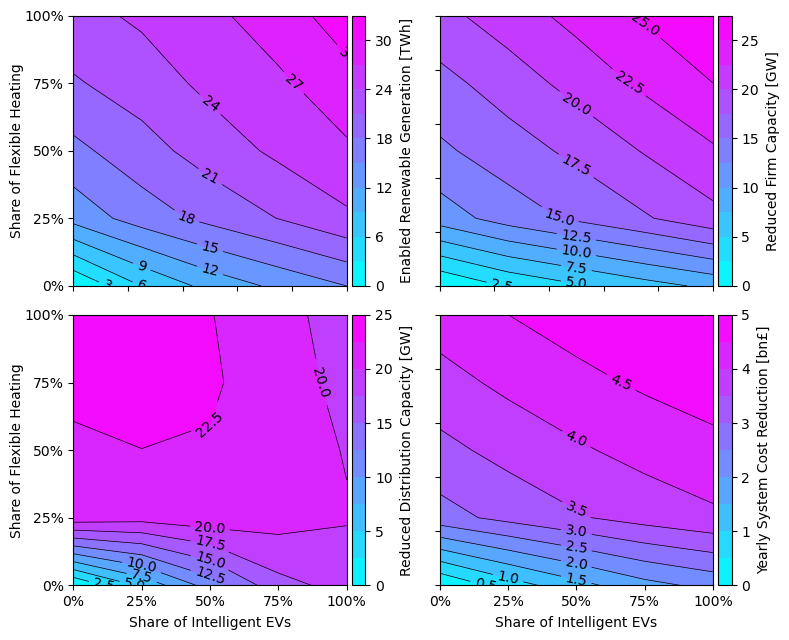

In [10]:
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

# fig = plt.figure(figsize=(12, 12))
fig, axs = plt.subplots(2, 2, figsize=(8, 6.5))

# orders = [-1, 1, 1]
orders = [-1, -1, -1, -1]
switches = [False, True, True, True]
factors = [1e-6, 1e-3, 1e-3, 1e-9]
zlabels = [
    "Enabled Renewable Generation [TWh]",
    "Reduced Firm Capacity [GW]",
    "Reduced Distribution Capacity [GW]",
    "Yearly System Cost Reduction [bn£]"]

less_better = {
    "renewable_energy": False,
    "dispatchable_capacity": True,
    "distribution": True,
    "system_cost": True,
}

for number, order, switch, factor, name, zlabel, ax in zip(
    range(1, 5),
    orders,
    switches,
    factors,
    ["renewable_energy", "dispatchable_capacity", "distribution", "system_cost"],
    zlabels,
    axs.flatten()
    ):

    # df = results[name].unstack().loc[s[::-1*order], s[::order]].mul(factor)
    df = results[name].unstack().mul(factor)
    z = df.values

    heat_shares, ev_shares = np.meshgrid(df.columns, df.index)

    if not less_better[name]:
        z -= z.min()
    else:
        z -= z.max()
        z = np.abs(z)

    cbar = ax.contourf(
        # xposM,
        # yposM,
        # dz.reshape(xposM.shape),
        heat_shares,
        ev_shares,
        z,
        # zdir='z',
        # offset=0,
        cmap=cm.cool,
        levels=10,
        )
    # cbar = fig.colorbar(cbar)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')
    # cbar.ax.set_ylabel(zlabel, labelpad=0)
    cbar.set_label(zlabel, labelpad=5)
    # cbar.set_ticklabels([])

    clines = ax.contour(
        # xposM,
        # yposM,
        # dz.reshape(xposM.shape),
        heat_shares,
        ev_shares,
        z,
        # cmap=cm.cool,
        colors=("k",),
        levels=10,
        linewidths=0.5,
    )
    ax.clabel(clines, inline=True, fontsize=10)


percentages = ["0%", "25%", "50%", "75%", "100%"]

for ax in axs[:,0]:
    ax.set_ylabel('Share of Flexible Heating', labelpad=0)
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_yticklabels(percentages)
for ax in axs[1,:]:
    ax.set_xlabel('Share of Intelligent EVs', labelpad=5)
    ax.xaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_xticklabels(percentages)
for ax in axs[:,1]:
    ax.set_yticklabels([])
for ax in axs[0,:]:
    ax.set_xticklabels([])


plt.tight_layout()
plt.savefig("overlapping_benefits.pdf", bbox_inches="tight")
plt.show()

array([['0%', '25%', '50%', '75%', '100%'],
       ['0%', '25%', '50%', '75%', '100%'],
       ['0%', '25%', '50%', '75%', '100%'],
       ['0%', '25%', '50%', '75%', '100%'],
       ['0%', '25%', '50%', '75%', '100%']], dtype='<U4')

C:\Users\lukas\AppData\Local\Temp\ipykernel_26156\172271935.py:3: UserWarning: The following kwargs were not used by contour: 'offset'
  cbar = ax.contourf(


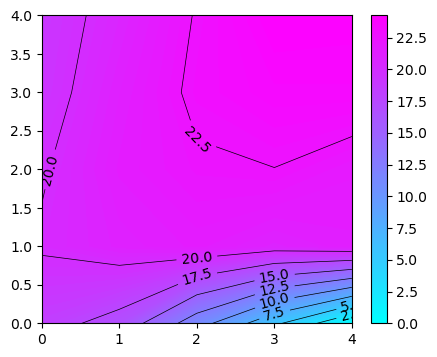

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

cbar = ax.contourf(
    xposM,
    yposM,
    dz.reshape(xposM.shape),
    # zdir='z',
    offset=0,
    cmap=cm.cool,
    levels=100,
    )
cbar = fig.colorbar(cbar)


clines = ax.contour(
    xposM,
    yposM,
    dz.reshape(xposM.shape),
    # cmap=cm.cool,
    colors=("k",),
    levels=10,
    linewidths=0.5,
)
ax.clabel(clines, inline=True, fontsize=10)

plt.show()